In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler




In [2]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


(0.0, 0.0)


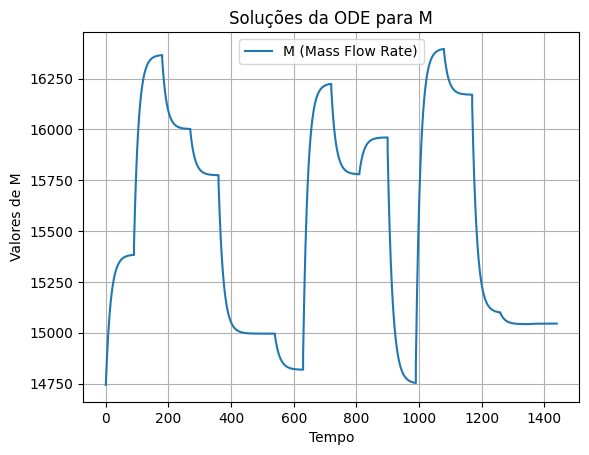

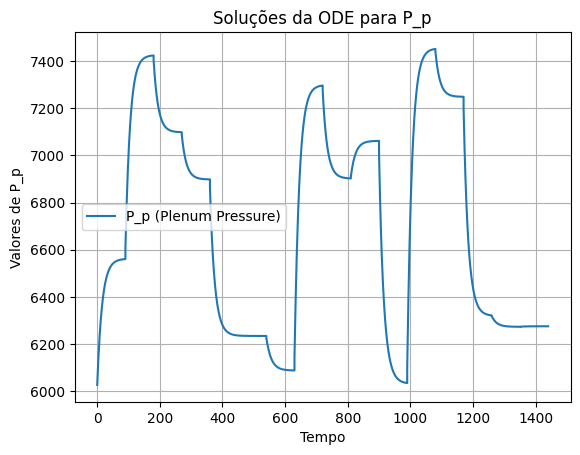

In [78]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4000, 5000)  # Corrigido para o intervalo desejado
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value


def ale():
  return np.random.uniform(4000, 5000)



p1_gen = P1Generator(seed)

def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0   # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1] - P_out)

    dmdt = (A1 / Lc) * (phi_value * 4000 - x[1])
    dPdt = ((C1**2) * (x[0] - alpha * K_nu * z)) / nu_P

    return dmdt, dPdt

stati = fsolve(Estacionario, [100000, 100000])

print(Estacionario(stati))

def Sistemas(x0, P1_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p')

    # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0  # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5  # φ

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))

    rhs = vertcat(
        (A1 / Lc) * (phi_value * p - (x[1])),
        (C1**2) * (x[0] - alpha * K_nu * z)
    ) / nu_P

    ode = {'x': x, 'ode': rhs , 'p': p}
    F = integrator('F', 'cvodes', ode, {'tf': 90})

    #
    t_eval = np.linspace(0, 90, 120)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    for i in range(len(t_eval)):
        res = F(x0=x0, p=P1_value)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next

        # Check for steady state
        if np.all(np.abs(x_next - x0) < zeronum):
            sol = sol[:i+1]
            t_eval = t_eval[:i+1]
            break

        # Update initial state
        x0 = x_next

    return sol, P1_value, t_eval

# Loop de geração de dados
def Loop(loops, stati):
    estados = []
    p1_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:
            x0 = stati  # Inicializa com o estado estacionário
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()
        sol, P1_aleatorio, t_eval = Sistemas(x0, P1_v)
        estados.append(sol)
        p1_total.append(P1_aleatorio)

        # Tempo Total
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, t_total

aaaa, PlotP1, Plott = Loop(16, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]
P_p_final = Ploty[:, 1]

# Plotar os resultados
plt.figure()
plt.plot(Plott, Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')
plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(Plott, Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()




In [4]:

# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]


# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], np.repeat(P1_values, len(t_eval) // len(P1_values))[:len(M[:-1])]))
y = np.column_stack((M[1:], P_p[1:]))


# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], np.repeat(P1_values, len(t_eval) // len(P1_values))[:len(M[:-1])]))
y = np.column_stack((M[1:], P_p[1:]))

# Dividir os dados em treino e teste
split_index = len(X) // 2
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Padronizar Dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Modelo em PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.Tanh()
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 2*hidden_dim por ser bidirecional

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) * 2)  # Concatenar saídas bidirecionais
        x = self.dropout(h_n)
        x = self.fc(x)
        return x

# Definir parâmetros do modelo
input_dim = X_train_tensor.shape[2]
hidden_dim = 64
output_dim = 2
dropout_rate = 0.006026506341105087
learning_rate = 0.0019532369421969473

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinamento do modelo
n_epochs = 1000
batch_size = 128
early_stop_patience = 10

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Para armazenar as perdas de treino e validação
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 0

for epoch in range(n_epochs):
    model.train()
    batch_train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
    
    # Perda média do treino na época atual
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    
    # Avaliação no conjunto de validação
    model.eval()
    with torch.no_grad():
        batch_val_losses = [criterion(model(X_val), y_val).item() for X_val, y_val in test_loader]
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Carregar o melhor modelo salvo
model.load_state_dict(best_model)

Epoch 1/1000, Train Loss: 0.8955566585063934, Val Loss: 0.9490441298112273
Epoch 2/1000, Train Loss: 0.7029312178492546, Val Loss: 0.6999982791021466
Epoch 3/1000, Train Loss: 0.48287635669112206, Val Loss: 0.4237156643066555
Epoch 4/1000, Train Loss: 0.2551487050950527, Val Loss: 0.1707302142167464
Epoch 5/1000, Train Loss: 0.07602713815867901, Val Loss: 0.03952876366383862
Epoch 6/1000, Train Loss: 0.01498708431608975, Val Loss: 0.03886728861834854
Epoch 7/1000, Train Loss: 0.0230871073435992, Val Loss: 0.04325367114506662
Epoch 8/1000, Train Loss: 0.017571532167494297, Val Loss: 0.0278903505532071
Epoch 9/1000, Train Loss: 0.009933603752870113, Val Loss: 0.02449926624831278
Epoch 10/1000, Train Loss: 0.009815064026042819, Val Loss: 0.02364321975619532
Epoch 11/1000, Train Loss: 0.009271794697269797, Val Loss: 0.021568010008195415
Epoch 12/1000, Train Loss: 0.008118363446556032, Val Loss: 0.020508396613877267
Epoch 13/1000, Train Loss: 0.007885377912316471, Val Loss: 0.01919824897777

<All keys matched successfully>

In [79]:
# Carregar o melhor modelo salvo
model.load_state_dict(best_model)

# Avaliação final com o conjunto de teste
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_loss = criterion(y_test_pred, y_test_tensor)
    print(f"Teste Loss: {test_loss.item()}")

Teste Loss: 0.00018173056014347821


<Figure size 2400x400 with 0 Axes>

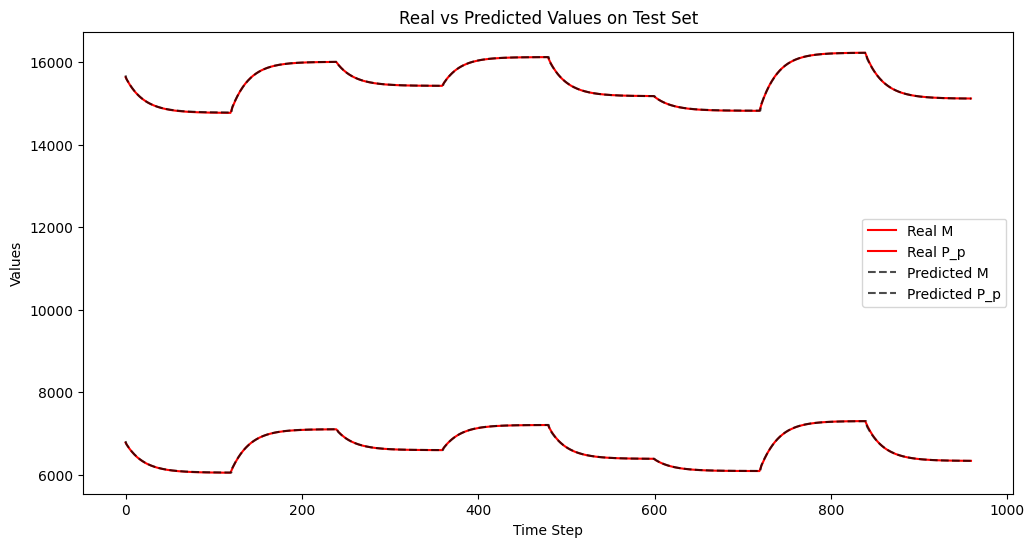

In [80]:
# Despadronizar para obter valores origina
# is
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.numpy())
y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plotagem das perdas de treinamento e validação
plt.figure(figsize=(24, 4))
# Plotagem das predições vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:, 0], label="Real M", color="red")
plt.plot(y_test_original[:, 1], label="Real P_p", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predicted M", color="black", alpha=0.7)
plt.plot(y_test_pred_original[:, 1], "--", label="Predicted P_p", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.title("Real vs Predicted Values on Test Set")
plt.legend()
plt.show()

In [88]:

t_total_predicoes = []

# Configuração para o número de estados e pontos por estado
num_estados = 10
steps = 9000  
t_eval = np.linspace(0, 90, steps)  # Intervalo de tempo para cada estado

# Colocar o modelo em modo de avaliação
model.eval()

# Usar os valores finais do Loop como ponto de partida para M e P_p
estados, PlotP1, t_total_reais = Loop(num_estados, stati)




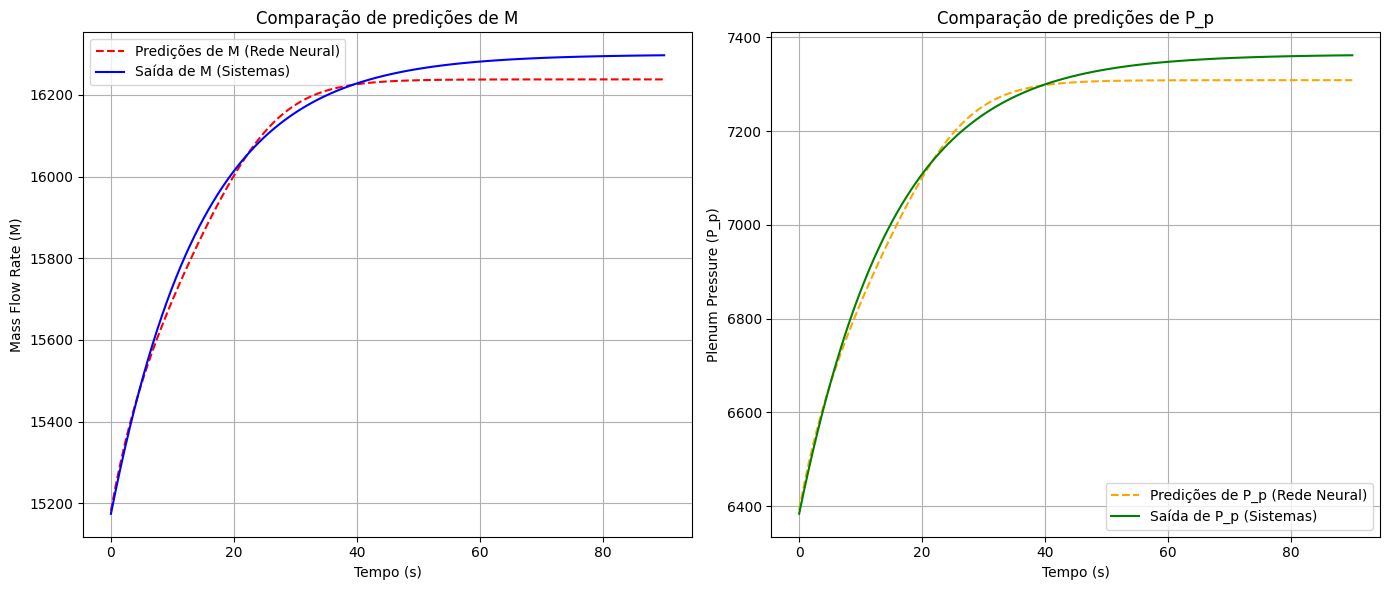

In [101]:
# Listas para armazenar as predições da rede neural
M_predicoes = []
P_p_predicoes = []

# Usar os últimos valores de M e P_p como ponto de partida
M_atual = M[-1]
P_p_atual = P_p[-1]
ultimo_P1 = p1_gen.P1()

t_eval = np.linspace(0, 90, 120)

# Colocar o modelo em modo de avaliação
model.eval()

# Iterar para gerar predições single-step
with torch.no_grad():
    for _ in range(120):
        # Criar a entrada com o formato (M_atual, P_p_atual, ultimo_P1)
        entrada = np.array([[M_atual, P_p_atual, ultimo_P1]])
        entrada_normalizada = scaler_X.transform(entrada)
        
        # Converter para tensor e adicionar a dimensão do lote
        entrada_tensor = torch.tensor(entrada_normalizada, dtype=torch.float32).unsqueeze(1)
        
        # Realizar a predição
        predicao = model(entrada_tensor).squeeze(0)
        
        # Inverter a padronização para obter valores nas escalas originais
        predicao_original = scaler_y.inverse_transform(predicao.cpu().numpy().reshape(1, -1))
        
        # Extrair os valores preditos para M e P_p
        M_predito = predicao_original[0, 0]
        P_p_predito = predicao_original[0, 1]
        
        # Armazenar as predições
        M_predicoes.append(M_predito)
        P_p_predicoes.append(P_p_predito)
        
        # Atualizar os valores reais para a próxima iteração
        M_atual = M_predito
        P_p_atual = P_p_predito

# Gerar os valores de saída da função Sistemas para comparação
sol_sistemas, _, t_eval_sistemas = Sistemas([M[-1], P_p[-1]], ultimo_P1)
M_sistemas = sol_sistemas[:, 0]
P_p_sistemas = sol_sistemas[:, 1]

# Plotar as previsões e os valores de saída da função Sistemas
plt.figure(figsize=(14, 6))

# Plotagem do M
plt.subplot(1, 2, 1)
plt.plot(t_eval, M_predicoes, label='Predições de M (Rede Neural)', color='red', linestyle='--')
plt.plot(t_eval_sistemas, M_sistemas, label='Saída de M (Sistemas)', color='blue', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação de predições de M')
plt.legend()
plt.grid(True)

# Plotagem do P_p
plt.subplot(1, 2, 2)
plt.plot(t_eval, P_p_predicoes, label='Predições de P_p (Rede Neural)', color='orange', linestyle='--')
plt.plot(t_eval_sistemas, P_p_sistemas, label='Saída de P_p (Sistemas)', color='green', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação de predições de P_p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


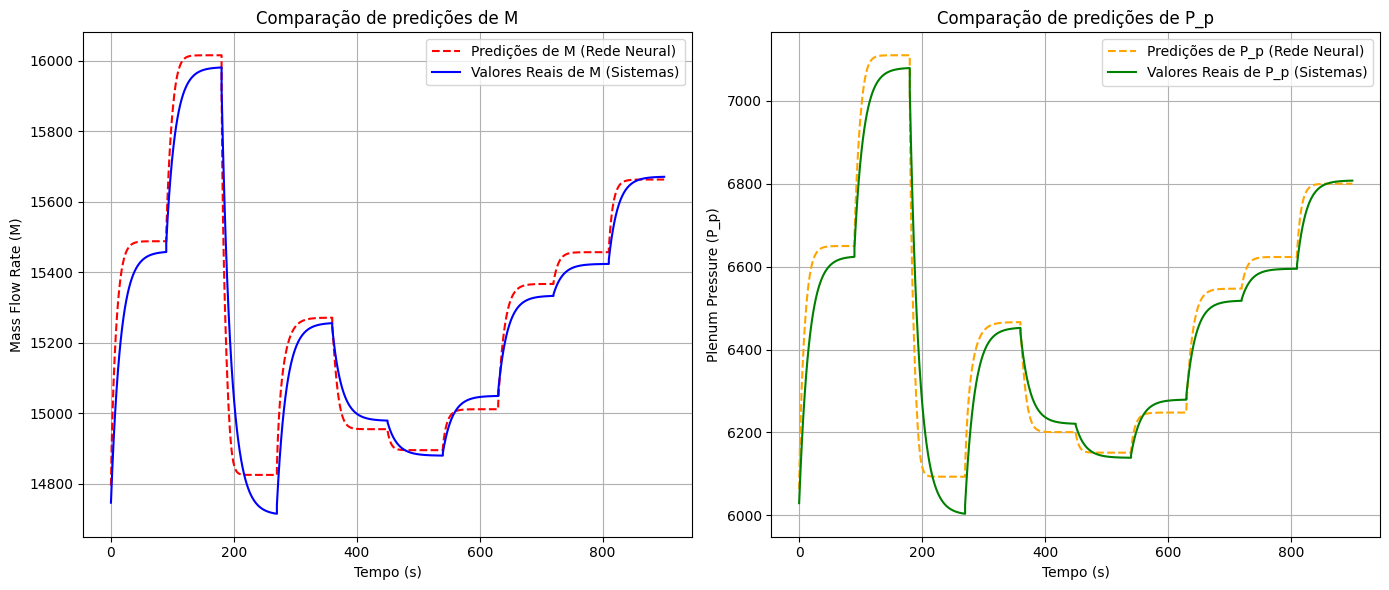

In [167]:

# Listas para armazenar as predições da rede neural
M_predicoes = []
P_p_predicoes = []
t_total_predicoes = []

# Configuração para o número de estados e pontos por estado
num_estados = 10
intervalo_por_estado = 240  


# Colocar o modelo em modo de avaliação
model.eval()

t_total_predicoes
p1_gen = P1Generator(1)

# Usar os valores finais do Loop como ponto de partida para M e P_p
estados, PlotP1, t_total_reais = Loop(num_estados, stati)
M_reais = np.concatenate([estado[:, 0] for estado in estados])
P_p_reais = np.concatenate([estado[:, 1] for estado in estados])

# Definindo os valores iniciais de M e P_p
M_atual = M_reais[0]
P_p_atual = P_p_reais[0]

# Iterar para gerar predições para múltiplos estados
with torch.no_grad():
    for estado in range(num_estados):
        ultimo_P1 = PlotP1[estado]
        
        # Realizar predições single-step para o intervalo do estado atual
        for t in t_eval:
            # Criar a entrada com o formato (M_atual, P_p_atual, ultimo_P1)
            entrada = np.array([[M_atual, P_p_atual, ultimo_P1]])
            entrada_normalizada = scaler_X.transform(entrada)
            
            # Converter para tensor e adicionar a dimensão do lote
            entrada_tensor = torch.tensor(entrada_normalizada, dtype=torch.float32).unsqueeze(1)
            
            # Realizar a predição
            predicao = model(entrada_tensor).squeeze(0)
            
            # Inverter a padronização para obter valores nas escalas originais
            predicao_original = scaler_y.inverse_transform(predicao.cpu().numpy().reshape(1, -1))
            
            # Extrair os valores preditos para M e P_p
            M_predito = predicao_original[0, 0]
            P_p_predito = predicao_original[0, 1]
            
            # Armazenar as predições e o tempo correspondente
            M_predicoes.append(M_predito)
            P_p_predicoes.append(P_p_predito)
            t_total_predicoes.append(t + estado * t_eval[-1])  # Acumular tempo para cada estado
            
            # Atualizar os valores reais para a próxima iteração
            M_atual = M_predito
            P_p_atual = P_p_predito

# Plotar as previsões e os valores reais
plt.figure(figsize=(14, 6))

# Plotagem do M
plt.subplot(1, 2, 1)
plt.plot(t_total_predicoes, M_predicoes, label='Predições de M (Rede Neural)', color='red', linestyle='--')
plt.plot(t_total_reais, M_reais, label='Valores Reais de M (Sistemas)', color='blue', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação de predições de M')
plt.legend()
plt.grid(True)

# Plotagem do P_p
plt.subplot(1, 2, 2)
plt.plot(t_total_predicoes, P_p_predicoes, label='Predições de P_p (Rede Neural)', color='orange', linestyle='--')
plt.plot(t_total_reais, P_p_reais, label='Valores Reais de P_p (Sistemas)', color='green', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação de predições de P_p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
